## Dimension Reduction ##

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.api import OLS # Pour la régression linéaire (avec statsmodels)
from statsmodels.tools.tools import add_constant # Pour l'ajout d'une constante dans statsmodels

from sklearn.preprocessing import PolynomialFeatures # Pour le "feature engineering" polynomial
import statsmodels.api as sm


In [3]:
df = pd.read_csv('Data/train_data.csv')
df = df.dropna()
print(df['vue_note'].mean())
df.head()
df.shape

0.23537645069108298


(17147, 21)

In [4]:
X = df.drop(['id', 'vue_mer', 'annee_construction', 'annee_renovation', 'zipcode', 'lat', 'long', 'date', 'vue_note'], axis = 1)
for column in X.columns:
    X[column] = (X[column] - X[column].mean())/X[column].std()
y = df['prix']
X = X.merge(df['vue_note'], left_index=True, right_index=True)
X.head()

,prix,nb_chambres,nb_sdb,m2_interieur,m2_jardin,m2_etage,m2_soussol,nb_etages,etat_note,design_note,m2_interieur_15voisins,m2_jardin_15voisins,vue_note
0,-0.167364,-1.471701,-1.452972,-0.505100,-0.271080,-1.050057,0.920698,-0.918126,0.909354,-0.565723,-0.957350,-0.330131,0
1,0.018315,-1.471701,-1.452972,-0.885012,0.679243,-0.629481,-0.656933,-0.918126,0.909354,-2.257910,-0.173772,-0.215901,0
2,-0.923670,-1.471701,0.811212,-0.537664,0.136950,-0.244954,-0.656933,0.004358,-0.630209,-2.257910,-0.986371,-0.251505,0
3,-0.480037,-0.398774,-0.482607,0.254722,-0.175401,-0.208905,0.920698,-0.918126,-0.630209,0.280370,0.000357,-0.113539,0
4,-0.196965,-0.398774,-0.159153,-0.309717,-0.060587,0.007391,-0.656933,-0.918126,-0.630209,-0.565723,-0.028665,-0.111500,0


# Interprétation des notes ###

In [5]:
def plot_density(note, df):
    plt.hexbin(df.loc[df['vue_note'] == note,'m2_interieur'], df.loc[df['vue_note'] == note,'prix'])
    plt.colorbar()
    plt.show()

def subplot_density(note, df, ax, fig):
    sp = ax.hexbin(df.loc[df['vue_note'] == note,'m2_interieur'], df.loc[df['vue_note'] == note,'prix'])
    ax.set_title('Note: ' + str(note))
    cb = fig.colorbar(sp, ax=ax)
    return sp

### Figure 1 ###

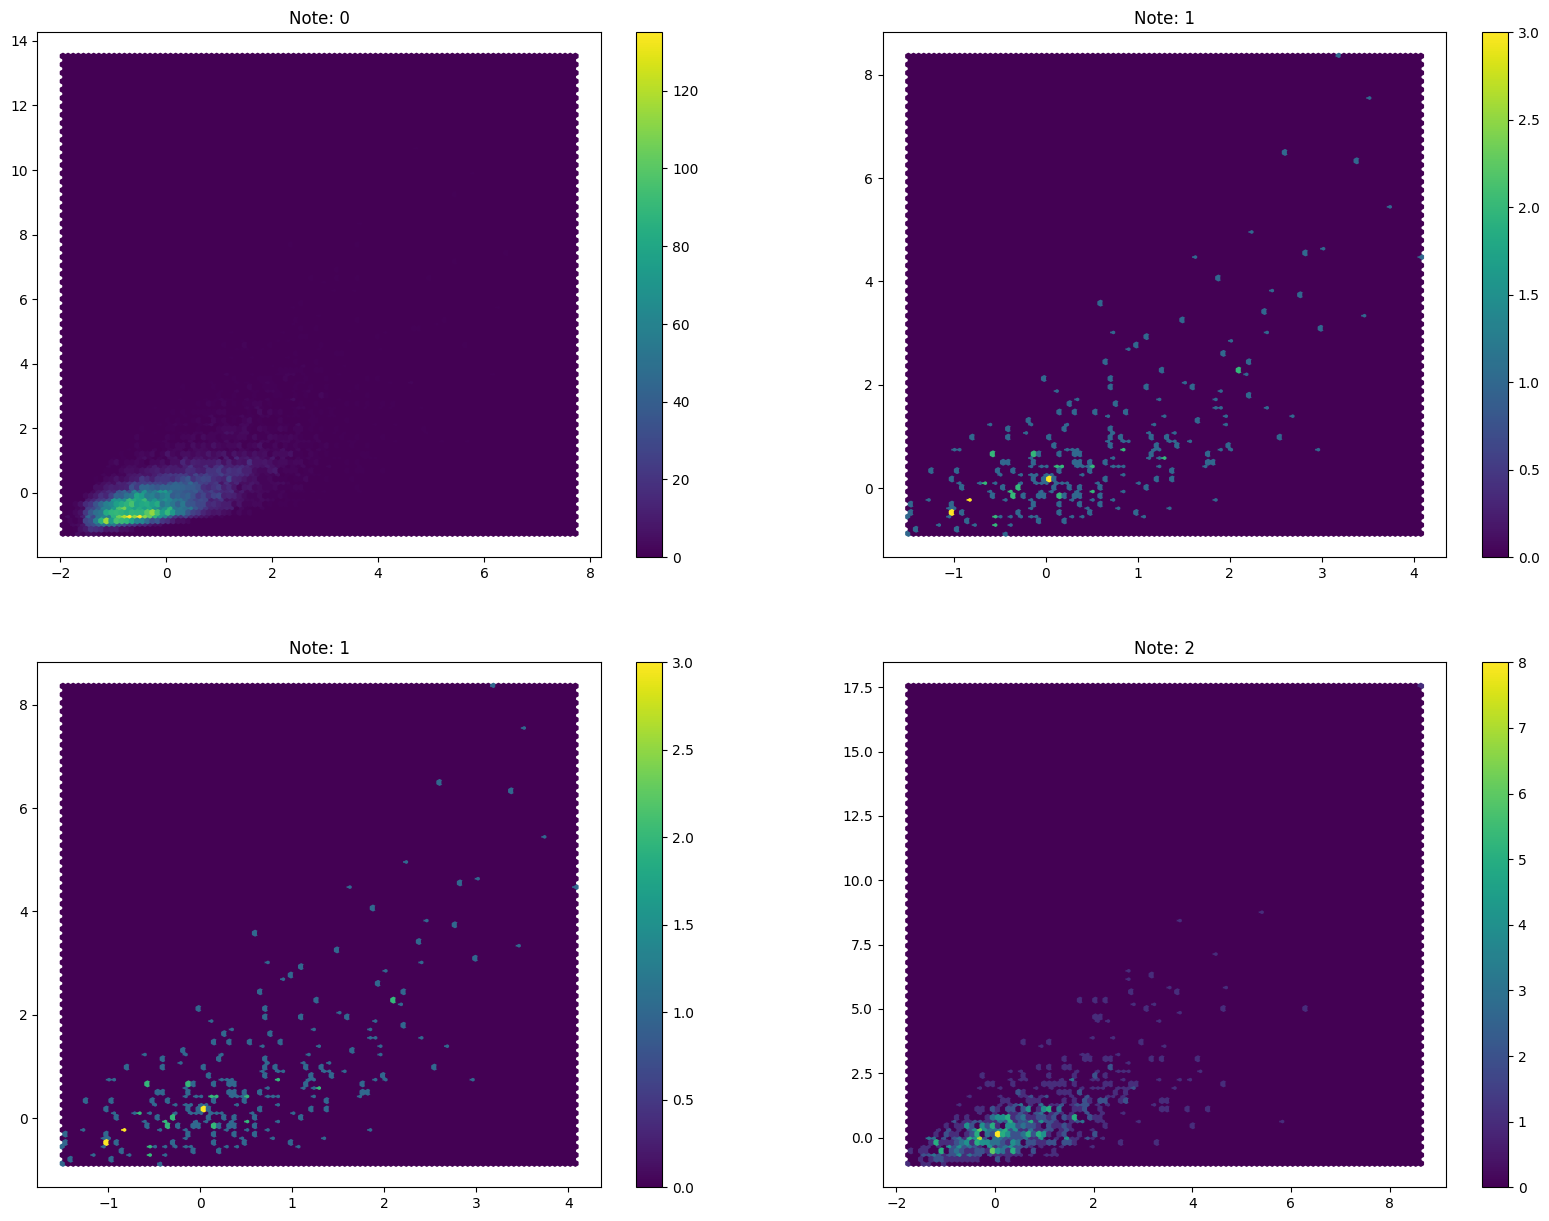

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
for i in range(2):
    for j in range(2):
        subplot_density(i + j, X, ax[i][j], fig)
plt.show()
X.drop('prix', axis = 1, inplace = True)


## Interprétation de la densité ##
On s'aperçoit que seule la catégorie note = 0 présente une condesation très forte de ses notes et de son prix (voir figure 1). On se propose d'élaborer un modèle unique pour ce cas de figure.

# Régressions #

# Régression linéaire #

0.595721113107789


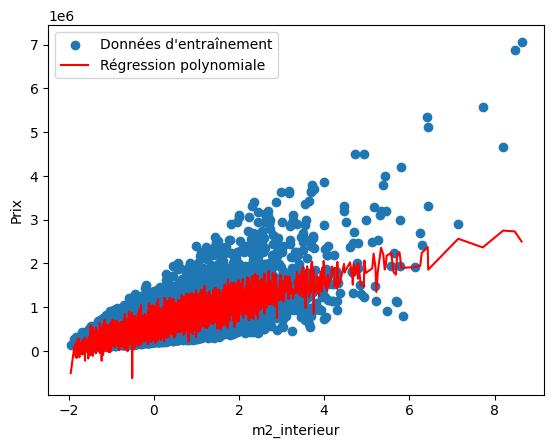

In [7]:
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
X_new = X.sort_values(by='m2_interieur', inplace=False)
y_pred = reg.predict(X_new)
plt.scatter(X['m2_interieur'], y, label='Données d\'entraînement')
#plt.scatter(X_test['m2_interieur'], y_test, label='Données de test')
plt.plot(X_new['m2_interieur'], y_pred, label='Régression polynomiale', color='red')
plt.xlabel('m2_interieur')
plt.ylabel('Prix')
plt.legend()
plt.show()

0.6900156160822615


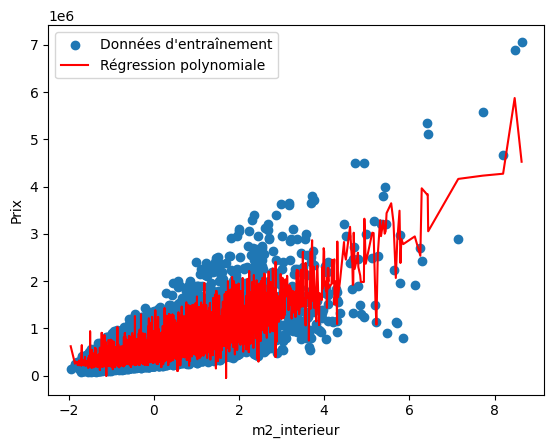

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un pipeline pour transformer les variables indépendantes en un polynôme de degré 2 et ajuster le modèle linéaire
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Ajuster le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Évaluer le modèle sur les données de test
score = model.score(X_test, y_test)

y_polreg = model.predict(X_new)
print(model.score(X, y))

# Tracer les résultats
plt.scatter(X_train['m2_interieur'], y_train, label='Données d\'entraînement')
#plt.scatter(X_test['m2_interieur'], y_test, label='Données de test')
plt.plot(X_new['m2_interieur'], y_polreg, label='Régression polynomiale', color='red')
plt.xlabel('m2_interieur')
plt.ylabel('Prix')
plt.legend()
plt.show()


## Pour l'instant, c'est notre meilleur score ##

# Régression en trois temps #
Au vu des densités de notes, on effectuera 3 régressions  
-Une pour la note de 0  
-Une dernière pour toutes les autres notes confondues

In [9]:
df_0 = df.loc[df['vue_note'] < 1]
df_1 = df.loc[df['vue_note'] >= 1]

In [10]:
X_0 = df_0.drop(['id', 'vue_mer', 'annee_construction', 'annee_renovation', 'zipcode', 'lat', 'long', 'date', 'vue_note', 'prix'], axis = 1)
for column in X_0.columns:
    X_0[column] = X_0[column] - X_0[column].mean()/X_0[column].std()
y_0 = df_0['prix']
X_1 = df_1.drop(['id', 'vue_mer', 'annee_construction', 'annee_renovation', 'zipcode', 'lat', 'long', 'date', 'vue_note', 'prix'], axis = 1)
for column in X_1.columns:
    X_1[column] = X_1[column] - X_1[column].mean()/X_1[column].std()
y_1 = df_1['prix']

In [11]:
X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size=0.2, random_state=42)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [12]:
model_0 = LinearRegression()
model_1 = LinearRegression()

model_0.fit(X_0_train, y_0_train)
model_1.fit(X_1_train, y_1_train)

print(model_0.score(X_0_test, y_0_test))
print(model_1.score(X_1_test, y_1_test))

0.5292210080678625
0.4989109264737632


In [13]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regressor
model_0 = DecisionTreeRegressor()
model_1 = DecisionTreeRegressor()

# Fit the model to the training data
model_0.fit(X_0_train, y_0_train)
model_1.fit(X_1_train, y_1_train)

# Evaluate the model
print(model_0.score(X_0_test, y_0_test))
print(model_1.score(X_1_test, y_1_test))


0.3785234327095798
0.14929899407284897


In [14]:
# Créer un pipeline pour transformer les variables indépendantes en un polynôme de degré 2 et ajuster le modèle linéaire
model_0 = LinearRegression()
model_1 = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Ajuster le modèle sur les données d'entraînement
model_0.fit(X_0_train, y_0_train)
model_1.fit(X_1_train, y_1_train)

# Évaluer le modèle sur les données de test
score_0 = model_0.score(X_0_test, y_0_test)
score_1 = model_1.score(X_1_test, y_1_test)
print(score_0)
print(score_1)
print(model_0.score(X_0, y_0))
print(model_1.score(X_1, y_1))


0.5292210080678625
0.5359844920830578
0.539606741376117
0.6548760524776438


In [15]:
df_test = pd.read_csv('Data/test_data.csv')
df_test = df_test.dropna()
X_teste = df_test.drop(['id', 'vue_mer', 'annee_construction', 'annee_renovation', 'zipcode', 'lat', 'long', 'date', 'vue_note'], axis = 1)

X_teste_0 = X_teste.loc[df_test['vue_note'] == 0]
X_teste_1 = X_teste.loc[df_test['vue_note'] > 0]
y_pred_0 = pd.Series(model_0.predict(X_teste_0), name='prix')  # name is optional, just for clarity
y_pred_1 = pd.Series(model_1.predict(X_teste_1), name='prix')

y_pred = pd.concat([y_pred_0, y_pred_1], axis=0, ignore_index=True)

#create the csv result.csv that concatenate the id and the predicted price


In [16]:
result = pd.concat([df_test['id'], y_pred], axis=1)
result.columns = ['id', 'prix']
result.to_csv('Data/result.csv', index=False)

#### Nouvel essai

In [17]:
# X_simple = df.loc[df['prix']>df['prix'].quantile(0.05),['m2_etage', 'm2_jardin','m2_etage','m2_soussol','nb_etages']]
# y_simple = df.loc[df['prix']>df['prix'].quantile(0.05),'prix']
X_simple = df[['m2_etage', 'm2_jardin','m2_etage','m2_soussol','nb_etages','vue_note']]
y_simple = df['prix']

In [18]:
# from sklearn.linear_model import LinearRegression
# from statsmodels.regression.linear_model import OLS
# import statsmodels.api as sm

# def calculate_leverage_cooks(X, y):
#     model = OLS(y, sm.add_constant(X)).fit()
#     leverage = model.get_influence().hat_matrix_diag
#     cooks_distance = model.get_influence().cooks_distance[0]
#     return leverage, cooks_distance

# # Calculer le Leverage et la Cook's Distance pour X_simple et y
# leverage, cooks_distance = calculate_leverage_cooks(X_simple, y)

In [19]:
# leverage_threshold = 2 * np.mean(leverage)
# cooks_distance_threshold = 10 / len(y)

# influential_observations = (leverage > leverage_threshold) | (cooks_distance > cooks_distance_threshold)

# # Créer un nouveau jeu de données sans les observations influentes
# X_reduced = X_simple[~influential_observations]
# y_reduced = y[~influential_observations]

# print("Nombre d'observations supprimées :", influential_observations.sum())


In [20]:
X_OLS = df.drop(['date','lat','long','prix','id'], axis = 1)
y_OLS = df['prix']
# Python

In [21]:
linreg_poly_model = OLS(y_OLS, add_constant(X_OLS))
linreg_poly = linreg_poly_model.fit()
linreg_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prix   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2175.
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:36:29   Log-Likelihood:            -2.3511e+05
No. Observations:               17147   AIC:                         4.702e+05
Df Residuals:                   17131   BIC:                         4.704e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    7.74e+06   3.55e+06      2.181      0.029    7.82e+05    1.47e+07
nb_chambres            -3.792e+04   2296.370    -16.513      0.000   -4.24e+04   -3.34e+04
nb_sdb                  4.596e+04   3947.478     11.643      0.000    3.82e+04    5.37e+04
m2_interieur            1177.0225     29.782     39.522      0.000    1118.647    1235.397
m2_jardin                  0.1392      0.605      0.230      0.818      -1.047       1.326
m2_etage                 553.9459     28.691     19.308      0.000     497.709     610.183
m2_soussol               623.0769     34.104     18.270      0.000     556.230     689.924
nb_etages                2.45e+04   4333.330      5.653      0.000     1.6e+04     3.3e+04
vue_mer                 5.465e+05   2.06e+04     26.513      0.000    5.06e+05    5.87e+05
vue_note                4.504e+04   2598.706     17.333      0.000    3.99e+04    5.01e+04
etat_note               2.036e+04   2869.772      7.093      0.000    1.47e+04     2.6e+04
design_note             1.236e+05   2547.556     48.530      0.000    1.19e+05    1.29e+05
annee_construction     -3587.8781     84.688    -42.366      0.000   -3753.875   -3421.881
annee_renovation           8.3747      4.411      1.898      0.058      -0.272      17.021
m2_interieur_15voisins   228.8014     44.440      5.149      0.000     141.694     315.909
m2_jardin_15voisins       -6.3624      0.944     -6.743      0.000      -8.212      -4.513
zipcode                  -15.6616     35.626     -0.440      0.660     -85.493      54.170
==============================================================================
Omnibus:                    12424.723   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           758514.678
Skew:                           2.888   Prob(JB):                         0.00
Kurtosis:                      35.067   Cond. No.                     2.32e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.07e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [22]:
X_OLS = df.drop(['date','lat','long','prix','id','m2_jardin','zipcode','annee_renovation'], axis = 1)
linreg_poly_model = OLS(y_OLS, add_constant(X_OLS))
linreg_poly = linreg_poly_model.fit()
linreg_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prix   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     2719.
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:36:29   Log-Likelihood:            -2.3511e+05
No. Observations:               17147   AIC:                         4.702e+05
Df Residuals:                   17134   BIC:                         4.703e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   6.281e+06   1.49e+05     42.237      0.000    5.99e+06    6.57e+06
nb_chambres            -3.796e+04   2290.982    -16.567      0.000   -4.24e+04   -3.35e+04
nb_sdb                  4.696e+04   3914.485     11.996      0.000    3.93e+04    5.46e+04
m2_interieur            1177.4536     29.711     39.630      0.000    1119.217    1235.691
m2_etage                 556.2349     28.420     19.572      0.000     500.528     611.941
m2_soussol               621.2188     33.799     18.380      0.000     554.969     687.468
nb_etages               2.448e+04   4264.533      5.741      0.000    1.61e+04    3.28e+04
vue_mer                 5.491e+05   2.06e+04     26.706      0.000    5.09e+05    5.89e+05
vue_note                4.504e+04   2583.167     17.434      0.000       4e+04    5.01e+04
etat_note               1.959e+04   2803.400      6.987      0.000    1.41e+04    2.51e+04
design_note             1.236e+05   2540.446     48.670      0.000    1.19e+05    1.29e+05
annee_construction     -3626.3732     76.409    -47.460      0.000   -3776.143   -3476.604
m2_interieur_15voisins   227.6754     43.673      5.213      0.000     142.072     313.279
m2_jardin_15voisins       -6.1655      0.689     -8.944      0.000      -7.517      -4.814
==============================================================================
Omnibus:                    12425.211   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           757107.039
Skew:                           2.889   Prob(JB):                         0.00
Kurtosis:                      35.036   Cond. No.                     6.36e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.75e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [23]:
# Python
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.api import OLS, add_constant

# Define the degree of the polynomial features
degree = 2

# Create a PolynomialFeatures object
poly = PolynomialFeatures(degree)

# Transform the data
X_poly = poly.fit_transform(X_OLS)

# Fit the model
linreg_poly_model = OLS(y_OLS, add_constant(X_poly))
linreg_poly = linreg_poly_model.fit()

# Print the summary
print(linreg_poly.summary())

                            OLS Regression Results                            
Dep. Variable:                   prix   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     563.9
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:36:30   Log-Likelihood:            -2.3249e+05
No. Observations:               17147   AIC:                         4.652e+05
Df Residuals:                   17057   BIC:                         4.659e+05
Df Model:                          89                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.627e+07   9.49e+06      8.038      0.0

In [24]:
Model_simple = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
Model_simple.fit(X_simple, y_simple)
print(Model_simple.score(X_simple, y_simple))

0.6173446212175886


In [25]:
moyenne_vue = {}
ecart_type_vue = {}
for i in range(4):
    moyenne_vue[i] = df.loc[df['vue_note'] == i, 'prix'].mean()
    ecart_type_vue[i] = df.loc[df['vue_note'] == i, 'prix'].std()
moyenne_vue

{0: 498868.4278317152,
 1: 828399.1310861423,
 2: 797134.8745198464,
 3: 962859.2133676093}

In [26]:
def prediction(X):
    X_simple = X[['m2_etage', 'm2_jardin','m2_etage','m2_soussol','nb_etages']]
    naive_price = Model_simple.predict(X_simple) + moyenne_vue[X['vue_note']] / ecart_type_vue[X['vue_note']]
    return naive_price
    

In [27]:
df_test = pd.read_csv('Data/test_data.csv')
df_test = df_test.dropna()
X_teste = df_test.drop(['date','lat','long','id','m2_jardin','zipcode','annee_renovation'], axis = 1)
for index, row in X_teste.iterrows():
    if row['vue_note'] == 0:
        row['vue_note'] = 0.2355412897578056
X_teste_poly = poly.fit_transform(X_teste)
y_pred = linreg_poly.predict(sm.add_constant(X_teste_poly))
#create the csv result.csv that concatenate the id and the predicted price
y_pred = pd.Series(y_pred, name='prix')  # name is optional, just for clarity

In [28]:
result = pd.concat([df_test['id'], y_pred], axis=1)
result.columns = ['id', 'prix']
result.to_csv('Data/result.csv', index=False)

## On teste le xgboost

In [29]:
features = ['nb_chambres', 'm2_etage', 'nb_sdb', 'm2_interieur', 'm2_soussol','m2_jardin', 'nb_etages', 'vue_mer', 'vue_note', 'etat_note', 'design_note', 'annee_construction', 'annee_renovation', 'm2_interieur_15voisins', 'm2_jardin_15voisins', 'zipcode', 'lat', 'long']

In [30]:
X = df[features]

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [33]:
params = {
    'tree_method': 'hist',
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.33,
    'subsample':0.90,
    'learning_rate':0.01
    }

num_folds = 4  # nombre de plis pour la validation croisée
num_boost_round = 10000  # nombre de tours d'apprentissage

In [34]:
cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, nfold=num_folds, early_stopping_rounds=10, metrics='rmse')
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = ['test-rmse-mean', 'test-rmse-std', 'train-rmse-mean', 'train-rmse-std']
print(cv_results_df.head())


   test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0   368754.405906    1567.869541    368872.067007     4756.751095
1   365928.631872    1551.670776    366246.529869     4815.265003
2   363128.874505    1538.854407    363585.325420     4914.948907
3   360378.634542    1533.377483    360971.034529     4958.699248
4   357648.938334    1540.553071    358423.758011     5019.035714


In [35]:
model = xgb.train(params, dtrain,num_boost_round=cv_results_df['test-rmse-mean'].idxmin())

In [36]:
y_pred = model.predict(dtrain)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)


Mean Squared Error: 3364609685.0218644
R-squared Score: 0.9756382126960673


In [37]:
y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)


Mean Squared Error: 13821109718.226635
R-squared Score: 0.899829375614252


In [38]:
df_test = pd.read_csv('Data/test_data.csv')
df_test = df_test.dropna()
X_teste = df_test[features]
X_teste = xgb.DMatrix(X_teste)
y_pred = model.predict(X_teste)
#create the csv result.csv that concatenate the id and the predicted price
y_pred = pd.Series(y_pred, name='prix')  # name is optional, just for clarity
result = pd.concat([df_test['id'], y_pred], axis=1)
result.columns = ['id', 'prix']
result.to_csv('Data/result.csv', index=False)